In [4]:
# =========================================
# SECTION 4: Config Loading & Device Setup
# =========================================

import yaml
import torch
import random
import numpy as np

# Step 1: Load configuration files
with open("configs/mae_config.yaml", "r") as f:
    mae_cfg = yaml.safe_load(f)

with open("configs/vit_config.yaml", "r") as f:
    vit_cfg = yaml.safe_load(f)

print("✅ MAE and ViT configs loaded successfully")

# Step 2: Device selection (do this ONCE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", DEVICE)

# Step 3: Set random seeds for reproducibility
SEED = mae_cfg.get("seed", 42)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"🎯 Random seed set to {SEED}")

# Step 4: Sanity-check important config values
print("\n🔍 MAE CONFIG (key values)")
print("Image size:", mae_cfg["model"]["img_size"])
print("Patch size:", mae_cfg["model"]["patch_size"])
print("Mask ratio:", mae_cfg["model"]["mask_ratio"])
print("Batch size:", mae_cfg["training"]["batch_size"])
print("Epochs:", mae_cfg["training"]["epochs"])

print("\n🔍 ViT CONFIG (key values)")
print("Image size:", vit_cfg["model"]["img_size"])
print("Patch size:", vit_cfg["model"]["patch_size"])
print("Num classes:", vit_cfg["model"]["num_classes"])
print("Batch size:", vit_cfg["training"]["batch_size"])
print("Epochs:", vit_cfg["training"]["epochs"])


✅ MAE and ViT configs loaded successfully
🖥️ Using device: cuda
🎯 Random seed set to 42

🔍 MAE CONFIG (key values)
Image size: 224
Patch size: 16
Mask ratio: 0.75
Batch size: 8
Epochs: 100

🔍 ViT CONFIG (key values)
Image size: 224
Patch size: 16
Num classes: 2
Batch size: 8
Epochs: 50


In [5]:
# =========================================
# Focal Loss implementation
# =========================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits, targets, weight=self.weight, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [7]:
# =========================================
# SECTION 6A: ViT Dry Run (Shenzhen ONLY)
# =========================================

import torch
import torch.nn as nn

from src.data.transforms import get_vit_transforms
from src.data.datasets import get_vit_dataloaders
from src.models.vit import VisionTransformer

print("📦 Creating Shenzhen-only dataloaders...")

# ✔️ Correct usage (NO image_size argument)
vit_train_tf = get_vit_transforms(is_train=True)
vit_val_tf   = get_vit_transforms(is_train=False)

train_loader, val_loader, test_loader = get_vit_dataloaders(
    root_dirs=["data/Shenzhen"],
    transform_train=vit_train_tf,
    transform_val=vit_val_tf,
    batch_size=vit_cfg["training"]["batch_size"],
    num_workers=2
)

print("✅ Shenzhen dataloaders created")

# -------------------------------------------------
# Get ONE batch
# -------------------------------------------------
images, labels = next(iter(train_loader))

print("\n🔍 Batch details:")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", labels.unique())

# -------------------------------------------------
# Initialize ViT model
# -------------------------------------------------
vit = VisionTransformer(
    img_size=vit_cfg["model"]["img_size"],
    patch_size=vit_cfg["model"]["patch_size"],
    in_chans=1,   # grayscale
    num_classes=vit_cfg["model"]["num_classes"],
    embed_dim=vit_cfg["model"]["embed_dim"],
    depth=vit_cfg["model"]["depth"],
    num_heads=vit_cfg["model"]["num_heads"]
).to(DEVICE)

print("\n🧠 ViT model initialized")

# -------------------------------------------------
# Forward pass (NO training)
# -------------------------------------------------
criterion = nn.CrossEntropyLoss()

images = images.to(DEVICE)
labels = labels.to(DEVICE)

with torch.no_grad():
    outputs = vit(images)
    loss = criterion(outputs, labels)

print("\n▶️ Forward pass successful")
print("Output shape:", outputs.shape)
print("Loss value:", loss.item())

# -------------------------------------------------
# GPU memory check
# -------------------------------------------------
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\n🧠 GPU Memory → Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")


📦 Creating Shenzhen-only dataloaders...
ViT Training: {'Normal': 228, 'TB': 235, 'Total': 463}
ViT Validation: {'Normal': 49, 'TB': 50, 'Total': 99}
ViT Test: {'Normal': 49, 'TB': 51, 'Total': 100}
✅ Shenzhen dataloaders created


c:\Users\Gopi\Downloads\vit\.venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\Gopi\Downloads\vit\src\data\transforms.py:101: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
c:\Users\Gopi\Downloads\vit\src\data\transforms.py:103: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),



🔍 Batch details:
Images shape: torch.Size([8, 1, 224, 224])
Labels shape: torch.Size([8])
Unique labels: tensor([0, 1])

🧠 ViT model initialized

▶️ Forward pass successful
Output shape: torch.Size([8, 2])
Loss value: 0.7500382661819458

🧠 GPU Memory → Allocated: 0.35 GB | Reserved: 0.50 GB


In [8]:
# =========================================
# Compute class weights from training data
# =========================================

import torch

if vit_cfg["training"]["use_class_weights"]:
    labels_all = []
    for _, labels in train_loader:
        labels_all.extend(labels.tolist())

    labels_all = torch.tensor(labels_all)
    class_counts = torch.bincount(labels_all)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()

    class_weights = class_weights.to(DEVICE)

    print("📊 Class counts:", class_counts.tolist())
    print("⚖️ Class weights:", class_weights.tolist())
else:
    class_weights = None


📊 Class counts: [228, 235]
⚖️ Class weights: [0.5075594186782837, 0.4924405813217163]


In [9]:
# =========================================
# Optimizer (from vit_config.yaml)
# =========================================

opt_cfg = vit_cfg["training"]["optimizer"]

optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=opt_cfg["lr"],
    betas=tuple(opt_cfg.get("betas", (0.9, 0.999))),
    weight_decay=opt_cfg.get("weight_decay", 0.01),
)

print(
    f"🔧 Optimizer: AdamW | "
    f"LR: {opt_cfg['lr']} | "
    f"Weight decay: {opt_cfg.get('weight_decay', 0.01)}"
)

# AMP
use_amp = vit_cfg["training"]["use_amp"]
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


🔧 Optimizer: AdamW | LR: 0.0003 | Weight decay: 0.01


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3549459901.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [10]:
# =========================================
# Loss function (from config)
# =========================================

if vit_cfg["training"]["focal_loss"]:
    criterion = FocalLoss(
        gamma=vit_cfg["training"]["focal_gamma"],
        weight=class_weights
    )
    print("🧠 Using Focal Loss")
else:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("🧠 Using CrossEntropy Loss")


🧠 Using Focal Loss


In [11]:
# =========================================
# SECTION 6B: ViT Training (Sanity Run)
# =========================================

from tqdm import tqdm

EPOCHS = 2  # sanity run only
clip_grad = vit_cfg["training"]["clip_grad"]

print("\n🚀 Starting ViT training (sanity run)...")

for epoch in range(EPOCHS):
    vit.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = vit(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        # Gradient clipping
        if clip_grad is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(vit.parameters(), clip_grad)

        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  🔻 Loss: {epoch_loss:.4f}")
    print(f"  🎯 Accuracy: {epoch_acc:.2f}%")

print("\n✅ Sanity training complete")



🚀 Starting ViT training (sanity run)...


Epoch 1/2:   0%|          | 0/58 [00:00<?, ?it/s]C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\1816959669.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1/2: 100%|██████████| 58/58 [00:27<00:00,  2.13it/s]



Epoch 1 Summary:
  🔻 Loss: 0.1714
  🎯 Accuracy: 52.48%


Epoch 2/2: 100%|██████████| 58/58 [00:27<00:00,  2.08it/s]


Epoch 2 Summary:
  🔻 Loss: 0.0469
  🎯 Accuracy: 53.35%

✅ Sanity training complete


# NEXT IMPLEMENTATION - Proper ViT Training (Shenzhen)
Changes from sanity run:

Epochs: 25

Scheduler: CosineAnnealingLR (from config)

Validation after each epoch

Save best model

In [12]:
# =========================================
# Scheduler (from vit_config.yaml)
# =========================================

sched_cfg = vit_cfg["training"]["scheduler"]

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=vit_cfg["training"]["epochs"],
    eta_min=sched_cfg.get("min_lr", 1e-6)
)

print(
    f"📉 Scheduler: CosineAnnealingLR | "
    f"Min LR: {sched_cfg.get('min_lr', 1e-6)}"
)


📉 Scheduler: CosineAnnealingLR | Min LR: 1e-06


In [14]:
# =========================================
# Create checkpoint directories (SAFE)
# =========================================

from pathlib import Path

ckpt_dir = Path("checkpoints/vit")
ckpt_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory ready: {ckpt_dir.resolve()}")

✅ Checkpoint directory ready: C:\Users\Gopi\Downloads\vit\checkpoints\vit


In [15]:
# =========================================
# SECTION 6C: ViT Training (Shenzhen ONLY)
# =========================================

from sklearn.metrics import accuracy_score

EPOCHS = 25
best_val_acc = 0.0

print("\n🚀 Training ViT on Shenzhen dataset...")

for epoch in range(EPOCHS):
    # --------------------
    # TRAIN
    # --------------------
    vit.train()
    train_loss = 0.0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = vit(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if clip_grad:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(vit.parameters(), clip_grad)

        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

    scheduler.step()

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(y_true, y_pred) * 100

    # --------------------
    # VALIDATE
    # --------------------
    vit.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = vit(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(y_true, y_pred) * 100

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%"
    )

    # --------------------
    # Save best model
    # --------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit.state_dict(), "checkpoints/vit/vit_shenzhen_best.pth")

print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.2f}%")



🚀 Training ViT on Shenzhen dataset...


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/25 | Train Loss: 0.0322, Acc: 56.80% | Val Loss: 0.0296, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 02/25 | Train Loss: 0.0366, Acc: 50.76% | Val Loss: 0.0325, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 03/25 | Train Loss: 0.0324, Acc: 53.13% | Val Loss: 0.0296, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 04/25 | Train Loss: 0.0325, Acc: 55.51% | Val Loss: 0.0298, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 05/25 | Train Loss: 0.0304, Acc: 55.72% | Val Loss: 0.0292, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 06/25 | Train Loss: 0.0319, Acc: 53.35% | Val Loss: 0.0347, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 07/25 | Train Loss: 0.0306, Acc: 51.84% | Val Loss: 0.0317, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 08/25 | Train Loss: 0.0304, Acc: 50.76% | Val Loss: 0.0284, Acc: 53.54%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 09/25 | Train Loss: 0.0305, Acc: 55.08% | Val Loss: 0.0272, Acc: 68.69%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 10/25 | Train Loss: 0.0305, Acc: 53.13% | Val Loss: 0.0332, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 11/25 | Train Loss: 0.0332, Acc: 47.08% | Val Loss: 0.0324, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 12/25 | Train Loss: 0.0334, Acc: 50.54% | Val Loss: 0.0288, Acc: 71.72%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 13/25 | Train Loss: 0.0301, Acc: 52.48% | Val Loss: 0.0297, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 14/25 | Train Loss: 0.0297, Acc: 54.86% | Val Loss: 0.0330, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 15/25 | Train Loss: 0.0323, Acc: 50.32% | Val Loss: 0.0318, Acc: 49.49%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 16/25 | Train Loss: 0.0307, Acc: 56.16% | Val Loss: 0.0329, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 17/25 | Train Loss: 0.0309, Acc: 51.84% | Val Loss: 0.0285, Acc: 65.66%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 18/25 | Train Loss: 0.0304, Acc: 52.92% | Val Loss: 0.0287, Acc: 51.52%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 19/25 | Train Loss: 0.0302, Acc: 53.56% | Val Loss: 0.0274, Acc: 64.65%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 20/25 | Train Loss: 0.0292, Acc: 58.53% | Val Loss: 0.0296, Acc: 57.58%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 21/25 | Train Loss: 0.0296, Acc: 54.21% | Val Loss: 0.0281, Acc: 61.62%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 22/25 | Train Loss: 0.0302, Acc: 48.81% | Val Loss: 0.0293, Acc: 50.51%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 23/25 | Train Loss: 0.0298, Acc: 58.53% | Val Loss: 0.0278, Acc: 62.63%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 24/25 | Train Loss: 0.0287, Acc: 59.18% | Val Loss: 0.0263, Acc: 73.74%


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3785903337.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 25/25 | Train Loss: 0.0320, Acc: 52.27% | Val Loss: 0.0317, Acc: 50.51%

🏆 Best Validation Accuracy: 73.74%


In [16]:
# =========================================
# Load best ViT checkpoint
# =========================================

import torch

best_ckpt_path = "checkpoints/vit/vit_shenzhen_best.pth"

vit.load_state_dict(torch.load(best_ckpt_path, map_location=DEVICE))
vit.to(DEVICE)
vit.eval()

print("✅ Best ViT model loaded for evaluation")


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\3568375216.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(best_ckpt_path, map_location=D

✅ Best ViT model loaded for evaluation


In [17]:
# =========================================
# Inference on Shenzhen test set
# =========================================

import numpy as np

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = vit(images)
        probs = torch.softmax(outputs, dim=1)

        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())  # TB probability

print("✅ Test inference completed")


✅ Test inference completed


In [18]:
# =========================================
# Evaluation metrics
# =========================================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print("📊 Shenzhen Test Set Results")
print(f"Accuracy : {acc * 100:.2f}%")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "TB"]))


📊 Shenzhen Test Set Results
Accuracy : 72.00%
Precision: 0.6949
Recall   : 0.8039
F1-score : 0.7455
ROC-AUC  : 0.7711

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.63      0.69        49
          TB       0.69      0.80      0.75        51

    accuracy                           0.72       100
   macro avg       0.73      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



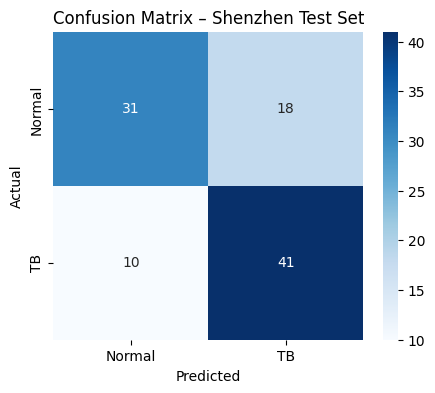

In [19]:
# =========================================
# Confusion matrix
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "TB"],
    yticklabels=["Normal", "TB"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Shenzhen Test Set")
plt.show()


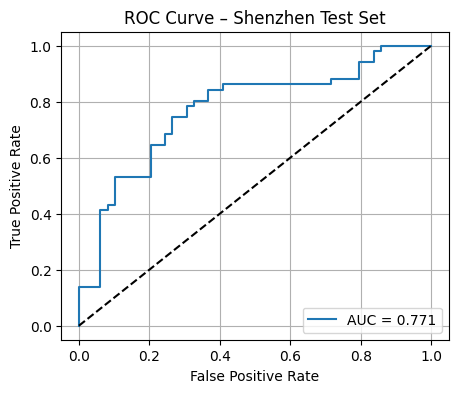

In [20]:
# =========================================
# ROC curve
# =========================================

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Shenzhen Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [21]:
# =========================================
# Combined Shenzhen + Montgomery dataloaders
# =========================================

train_loader, val_loader, test_loader = get_vit_dataloaders(
    root_dirs=[
        "data/Shenzhen",
        "data/Montgomery"
    ],
    transform_train=vit_train_tf,
    transform_val=vit_val_tf,
    batch_size=vit_cfg["training"]["batch_size"],
    num_workers=vit_cfg["training"]["num_workers"]
)

print("✅ Combined Shenzhen + Montgomery dataloaders ready")

ViT Training: {'Normal': 284, 'TB': 276, 'Total': 560}
ViT Validation: {'Normal': 60, 'TB': 59, 'Total': 119}
ViT Test: {'Normal': 62, 'TB': 59, 'Total': 121}
✅ Combined Shenzhen + Montgomery dataloaders ready


In [22]:
# =========================================
# Recompute class weights (combined dataset)
# =========================================

labels_all = []
for _, labels in train_loader:
    labels_all.extend(labels.tolist())

labels_all = torch.tensor(labels_all)
class_counts = torch.bincount(labels_all)

class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(DEVICE)

print("📊 Class counts:", class_counts.tolist())
print("⚖️ Class weights:", class_weights.tolist())


📊 Class counts: [284, 276]
⚖️ Class weights: [0.4928571283817291, 0.5071428418159485]


In [23]:
# =========================================
# ViT Training (Shenzhen + Montgomery)
# =========================================

EPOCHS = 30
best_val_acc = 0.0

for epoch in range(EPOCHS):
    vit.train()
    train_loss = 0.0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = vit(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if clip_grad:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(vit.parameters(), clip_grad)

        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

    scheduler.step()

    train_loss /= len(train_loader.dataset)
    train_acc = (torch.tensor(y_true) == torch.tensor(y_pred)).float().mean().item() * 100

    # ---------- VALIDATION ----------
    vit.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = vit(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = (torch.tensor(y_true) == torch.tensor(y_pred)).float().mean().item() * 100

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Acc: {train_acc:.2f}% | "
        f"Val Acc: {val_acc:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit.state_dict(), "checkpoints/vit/vit_combined_best.pth")

print(f"\n🏆 Best Combined Validation Accuracy: {best_val_acc:.2f}%")


C:\Users\Gopi\AppData\Local\Temp\ipykernel_32708\2211145224.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/30 | Train Acc: 57.68% | Val Acc: 54.62%
Epoch 02/30 | Train Acc: 58.39% | Val Acc: 57.14%
Epoch 03/30 | Train Acc: 61.96% | Val Acc: 49.58%
Epoch 04/30 | Train Acc: 60.54% | Val Acc: 63.87%
Epoch 05/30 | Train Acc: 51.25% | Val Acc: 50.42%
Epoch 06/30 | Train Acc: 55.71% | Val Acc: 60.50%
Epoch 07/30 | Train Acc: 61.07% | Val Acc: 55.46%
Epoch 08/30 | Train Acc: 56.43% | Val Acc: 50.42%
Epoch 09/30 | Train Acc: 60.00% | Val Acc: 53.78%
Epoch 10/30 | Train Acc: 59.11% | Val Acc: 64.71%
Epoch 11/30 | Train Acc: 59.11% | Val Acc: 61.34%
Epoch 12/30 | Train Acc: 59.11% | Val Acc: 55.46%
Epoch 13/30 | Train Acc: 58.04% | Val Acc: 59.66%
Epoch 14/30 | Train Acc: 63.57% | Val Acc: 56.30%
Epoch 15/30 | Train Acc: 63.93% | Val Acc: 57.98%
Epoch 16/30 | Train Acc: 64.11% | Val Acc: 56.30%
Epoch 17/30 | Train Acc: 64.11% | Val Acc: 62.18%
Epoch 18/30 | Train Acc: 62.68% | Val Acc: 57.14%
Epoch 19/30 | Train Acc: 61.96% | Val Acc: 63.03%
Epoch 20/30 | Train Acc: 66.96% | Val Acc: 59.66%
